## Import Necessary Libraries

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

from dask.distributed import Client, LocalCluster
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import SGDRegressor
from statsmodels.graphics.tsaplots import plot_acf


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Loading data

In [22]:
df = pd.read_csv('../../3_Data/processed/2025_hourly_all_clean.csv')
df.head()

,tpep_pickup_datetime,passenger_demand,taxi_demand
0,2025-01-01 00:00:00,9132,7344
1,2025-01-01 01:00:00,8996,8468
2,2025-01-01 02:00:00,7364,7257
3,2025-01-01 03:00:00,4904,4915
4,2025-01-01 04:00:00,3015,2918


In [23]:
df.tail()

,tpep_pickup_datetime,passenger_demand,taxi_demand
6566,2025-09-30 19:00:00,9595,9779
6567,2025-09-30 20:00:00,8882,9539
6568,2025-09-30 21:00:00,9048,9965
6569,2025-09-30 22:00:00,7026,8001
6570,2025-09-30 23:00:00,3984,4587


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6571 entries, 0 to 6570
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tpep_pickup_datetime  6571 non-null   object
 1   passenger_demand      6571 non-null   int64 
 2   taxi_demand           6571 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 154.1+ KB


In [25]:
df.describe()

,passenger_demand,taxi_demand
count,6571.000000,6571.000000
mean,5407.537513,5449.311520
std,3190.897504,3055.996053
min,0.000000,0.000000
25%,2208.500000,2574.500000
50%,6037.000000,6016.000000
75%,7957.000000,7582.000000
max,12923.000000,14039.000000


In [26]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')

In [27]:
df.loc[0, 'tpep_pickup_datetime'].dayofweek

2

In [28]:
df.loc[0, 'tpep_pickup_datetime'].dayofyear

1

In [29]:
# let's set "tpep_pickup_datetime" as index
data = df.set_index('tpep_pickup_datetime').copy()
data

,passenger_demand,taxi_demand
tpep_pickup_datetime,,
2025-01-01 00:00:00,9132,7344
2025-01-01 01:00:00,8996,8468
2025-01-01 02:00:00,7364,7257
2025-01-01 03:00:00,4904,4915
2025-01-01 04:00:00,3015,2918
...,...,...
2025-09-30 19:00:00,9595,9779
2025-09-30 20:00:00,8882,9539
2025-09-30 21:00:00,9048,9965


In [30]:
data.index.month

Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       ...
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
      dtype='int32', name='tpep_pickup_datetime', length=6571)

In [31]:
def add_timed_features(df: pd.DataFrame) -> pd.DataFrame:
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    return df

In [32]:
add_timed_features(data)

,passenger_demand,taxi_demand,hour,day,month,dayofweek
tpep_pickup_datetime,,,,,,
2025-01-01 00:00:00,9132,7344,0,1,1,2
2025-01-01 01:00:00,8996,8468,1,1,1,2
2025-01-01 02:00:00,7364,7257,2,1,1,2
2025-01-01 03:00:00,4904,4915,3,1,1,2
2025-01-01 04:00:00,3015,2918,4,1,1,2
...,...,...,...,...,...,...
2025-09-30 19:00:00,9595,9779,19,30,9,1
2025-09-30 20:00:00,8882,9539,20,30,9,1
2025-09-30 21:00:00,9048,9965,21,30,9,1


In [33]:
# data.sort_index(inplace=True)

In [34]:
# data = data.loc[data.index<"2025-01-01 00:00:00"]

In [35]:
# data

### Trend Analysis

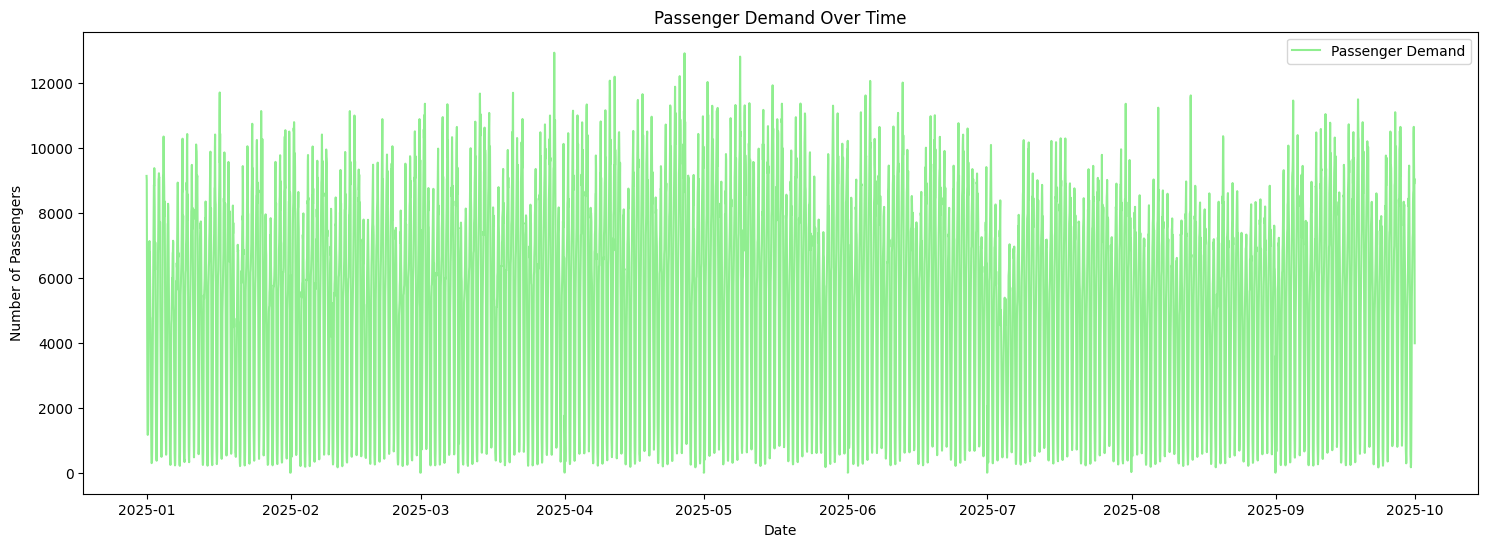

In [37]:
plt.figure(figsize=(18, 6))
plt.plot(data['passenger_demand'], label='Passenger Demand', color='lightgreen')
plt.title('Passenger Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

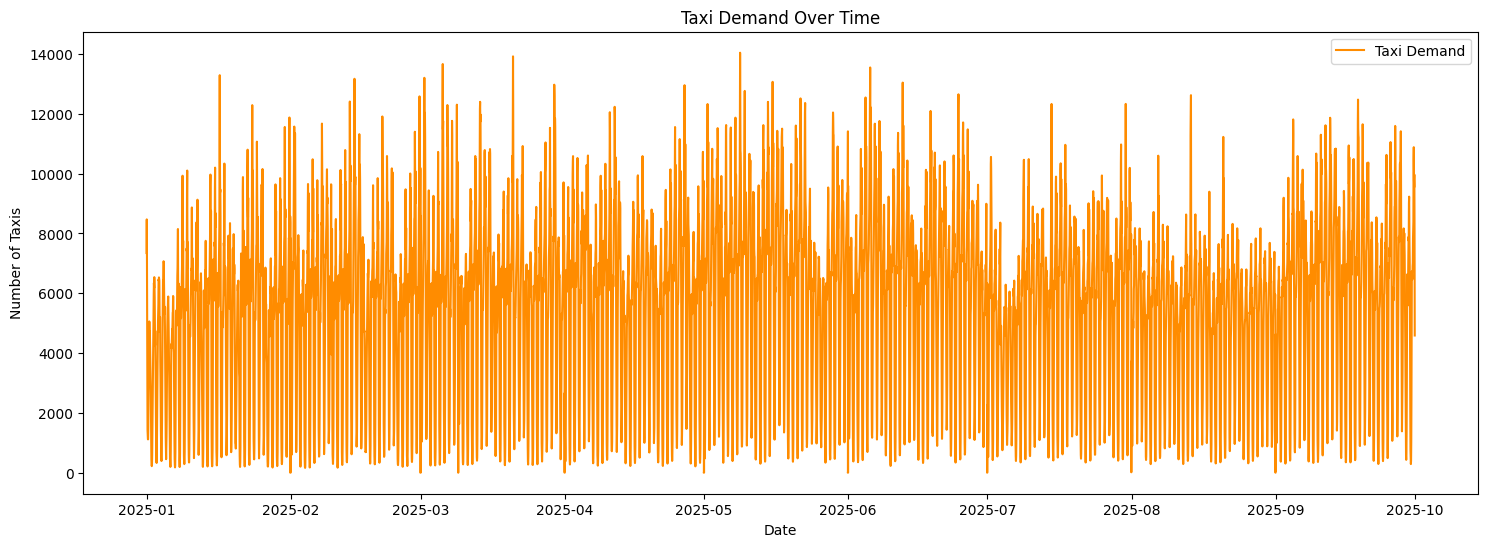

In [40]:
plt.figure(figsize=(18, 6))
plt.plot(data['taxi_demand'], label='Taxi Demand', color='darkorange')
plt.title('Taxi Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Taxis')
plt.legend()
plt.show()

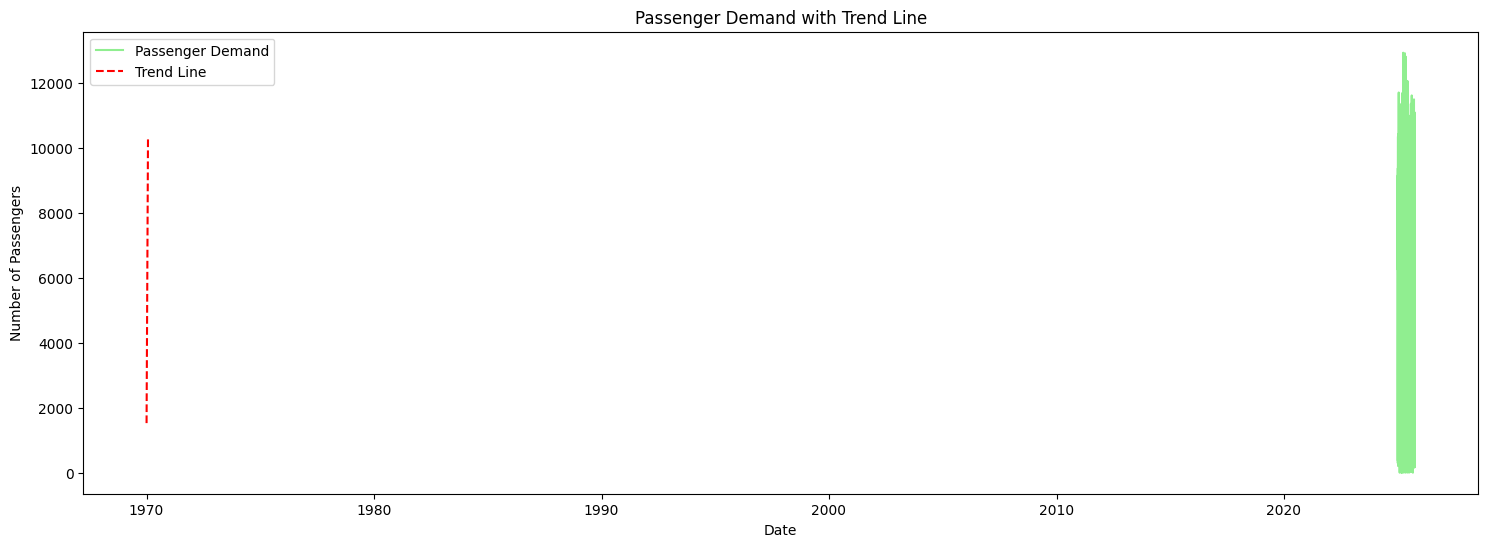

In [41]:
# Extract the date index as a numerical variable
x_values = data.index.hour.values.reshape(-1,1)

# Fit a linear regression model to estimate the trend
reg = SGDRegressor().fit(x_values, data['passenger_demand'])

# Visualize the trend line
trend_line = reg.predict(x_values)
plt.figure(figsize=(18, 6))
plt.plot(data['passenger_demand'], label='Passenger Demand', color='lightgreen')
plt.plot(data.index.hour.values, trend_line, label='Trend Line', color='red', linestyle='--')
plt.title('Passenger Demand with Trend Line')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

### Seasonality Analysis

In [ ]:
# Resample data to weekly frequency for seasonality analysis
weekly = data.resample('W').agg({'passenger_demand': 'sum', 'taxi_demand': 'count'})

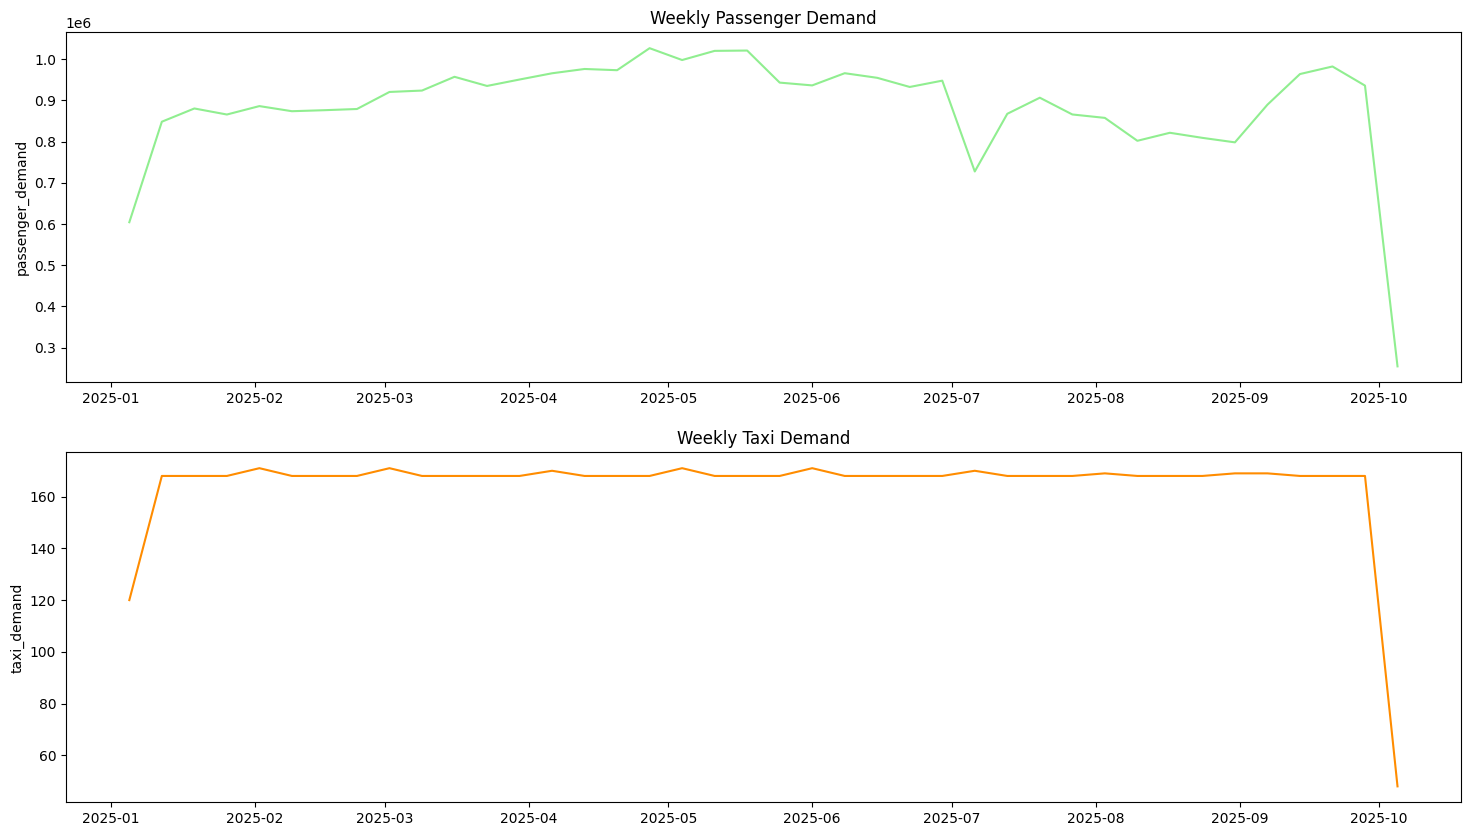

In [43]:
fig , grid = plt.subplots(2, 1, figsize=(18, 10))
sns.lineplot(data=weekly, x=weekly.index.values, y='passenger_demand', ax=grid[0], color='lightgreen')
grid[0].set_title('Weekly Passenger Demand')
sns.lineplot(data=weekly, x=weekly.index.values, y='taxi_demand', ax=grid[1], color='darkorange')
grid[1].set_title('Weekly Taxi Demand')
plt.show()

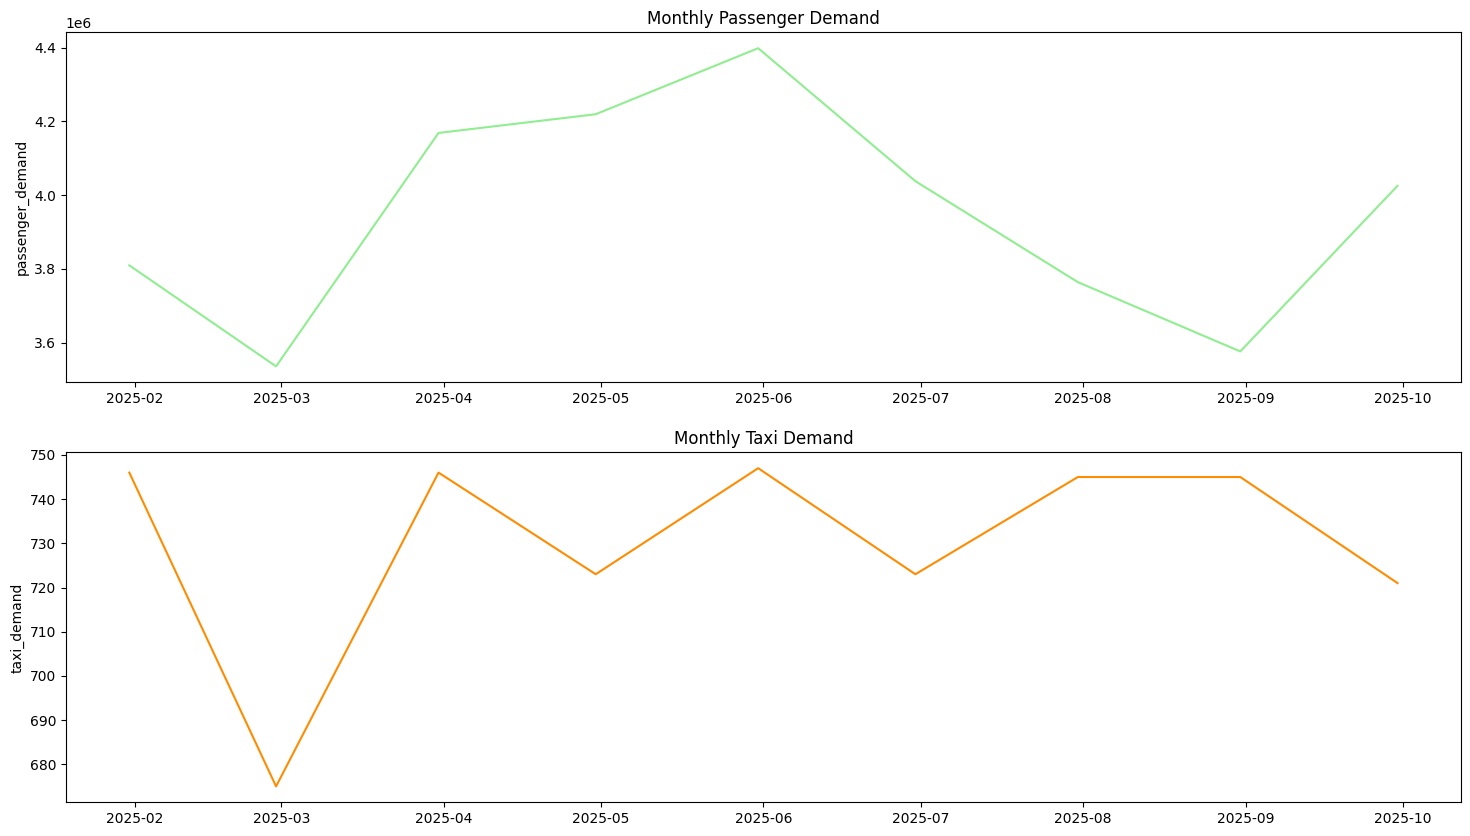

In [ ]:
# Monthly seasonality analysis 
monthly = data.resample('M').agg({'passenger_demand': 'sum', 'taxi_demand': 'count'})

fig , grid = plt.subplots(2, 1, figsize=(18, 10))
sns.lineplot(data=monthly, x=monthly.index.values, y='passenger_demand', ax=grid[0], color='lightgreen')
grid[0].set_title('Monthly Passenger Demand')
sns.lineplot(data=monthly, x=monthly.index.values, y='taxi_demand', ax=grid[1], color='darkorange')
grid[1].set_title('Monthly Taxi Demand')
plt.show()

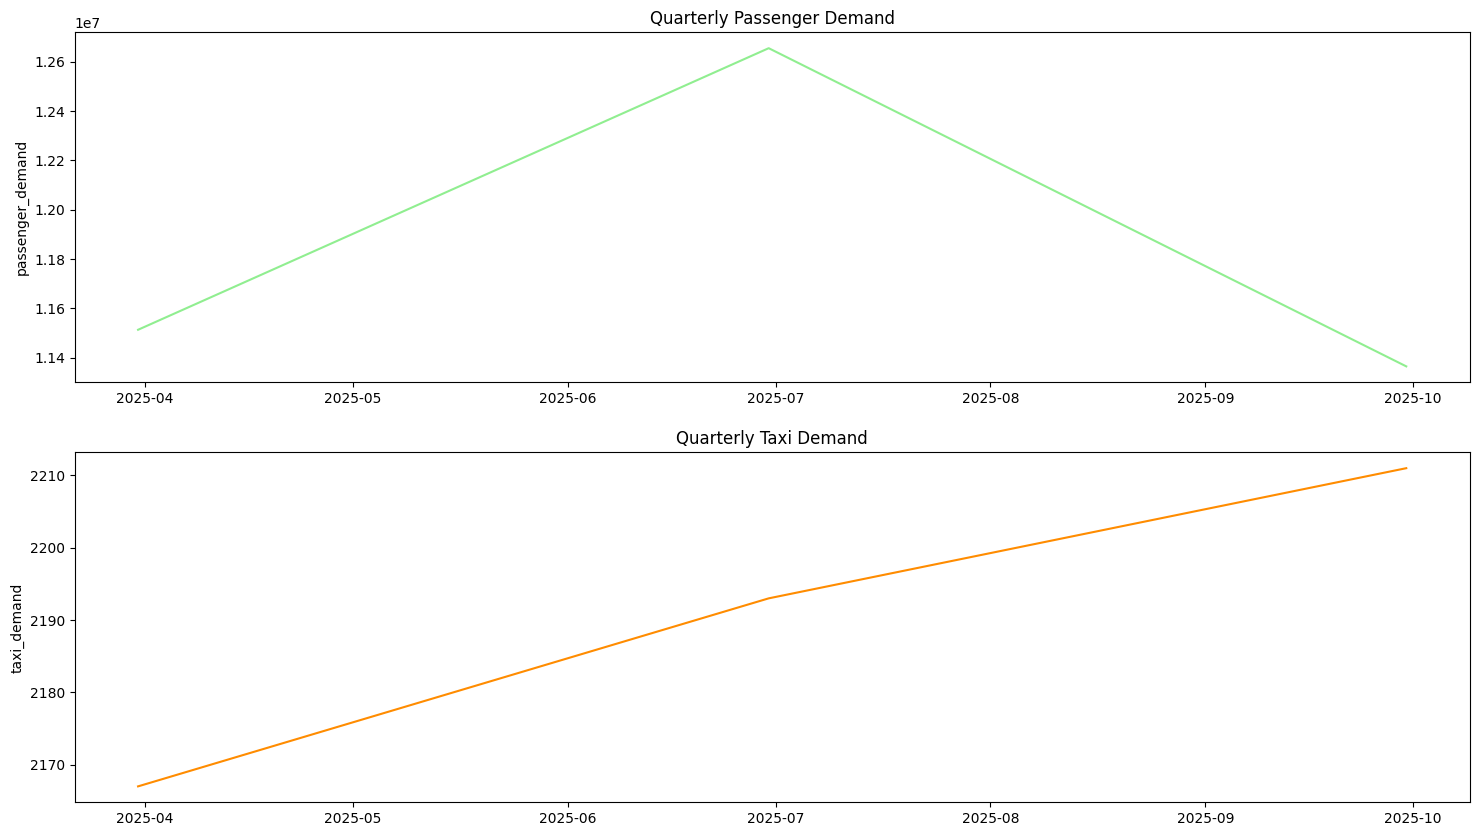

In [46]:
# Quarterly seasonality analysis
quarterly = data.resample('Q').agg({'passenger_demand': 'sum', 'taxi_demand': 'count'})

fig , grid = plt.subplots(2, 1, figsize=(18, 10))
sns.lineplot(data=quarterly, x=quarterly.index.values, y='passenger_demand', ax=grid[0], color='lightgreen')
grid[0].set_title('Quarterly Passenger Demand')
sns.lineplot(data=quarterly, x=quarterly.index.values, y='taxi_demand', ax=grid[1], color='darkorange')
grid[1].set_title('Quarterly Taxi Demand')
plt.show()

### Stationarity and Non-Stationarity Analysis

<b>A stationary time series has:</b> <br>
Constant mean over time 📉 <br>
Constant variance (no increasing/decreasing volatility) ⚖️ <br>
No trend or seasonality (flat, stable pattern) 📈 <br>


<b>A non-stationary series usually has:</b><br>
A visible trend (upward/downward drift)<br>
Changing variance<br>
Seasonal effects or cycles<br>

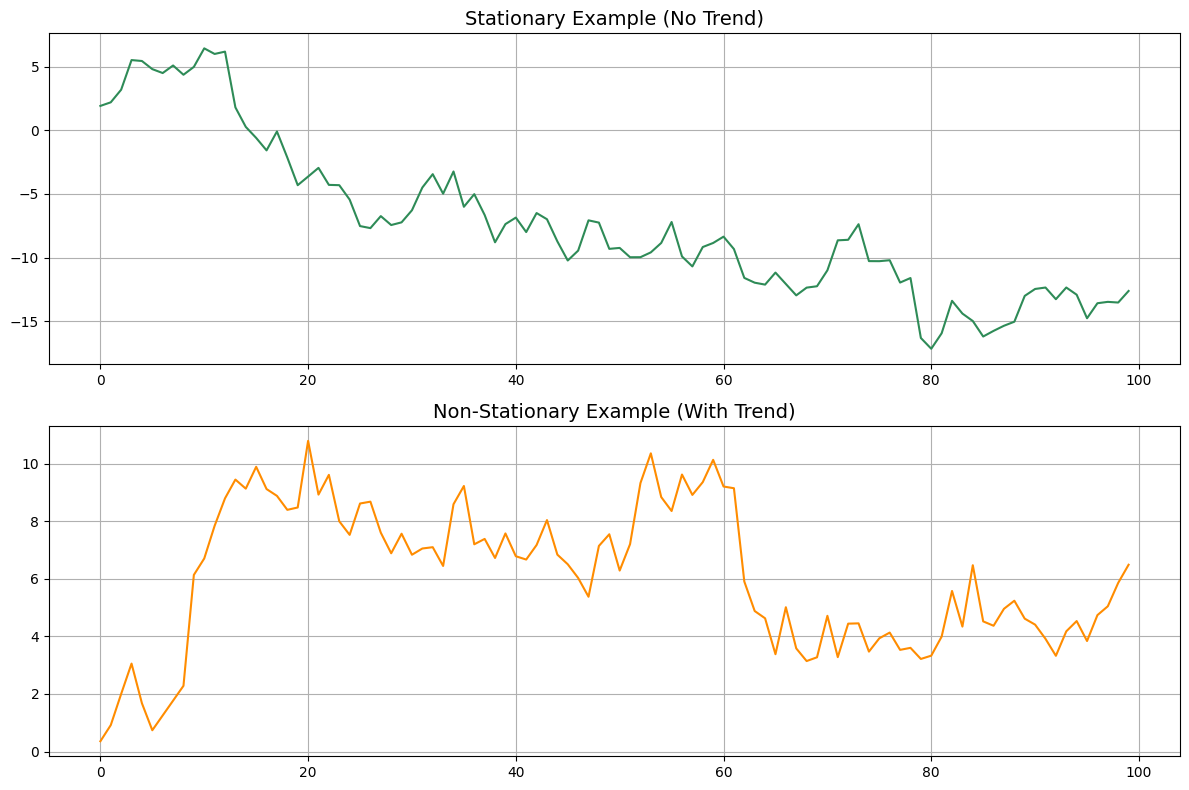

In [ ]:
# Create synthetic examples
np.random.seed(42)
stationary = np.random.randn(100).cumsum() - np.random.randn(100).cumsum()
non_stationary = np.cumsum(np.random.randn(100))

# Create vertical subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# Plot stationary example
axes[0].plot(stationary, color='seagreen')
axes[0].set_title('Stationary Example (No Trend)', fontsize=14)
axes[0].grid(True)

# Plot non-stationary example
axes[1].plot(non_stationary, color='darkorange')
axes[1].set_title('Non-Stationary Example (With Trend)', fontsize=14)
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [63]:
# Perform the ADF test on the time series data
result = adfuller(data['passenger_demand'])

# Extract the test statistic and p-value from the result
test_statistic = result[0]
p_value = result[1]

# Print the results
print(f"ADF Test Statistic: {test_statistic}")
print(f"p-value: {p_value}")

ADF Test Statistic: -8.929215854645292
p-value: 9.919735303415907e-15


In [69]:
9.91e-15 < 0.05

True

If p < 0.05 → Stationary<br>
If p > 0.05 → Non-stationary

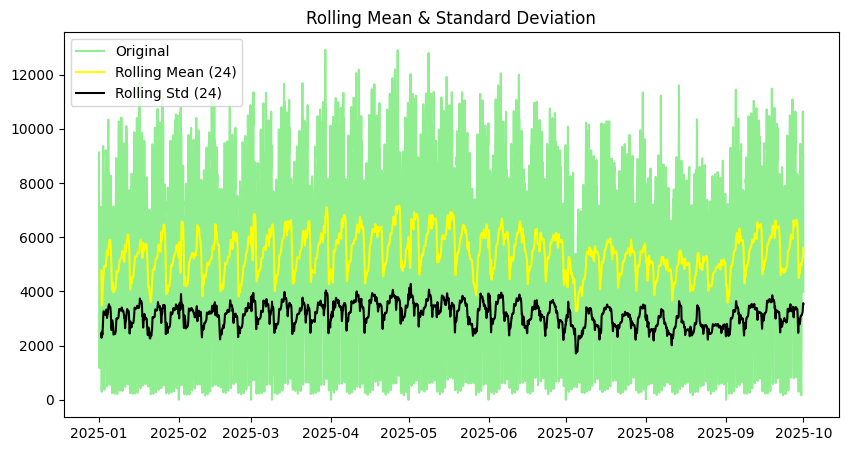

In [57]:
rolling_mean = data['passenger_demand'].rolling(window=24).mean()
rolling_std = data['passenger_demand'].rolling(window=24).std()

plt.figure(figsize=(10,5))
plt.plot(data['passenger_demand'], label='Original', color='lightgreen')
plt.plot(rolling_mean, label='Rolling Mean (24)', color='yellow')
plt.plot(rolling_std, label='Rolling Std (24)', color='black')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

### Autocorrelation Analysis

In [71]:
data

,passenger_demand,taxi_demand,hour,day,month,dayofweek
tpep_pickup_datetime,,,,,,
2025-01-01 00:00:00,9132,7344,0,1,1,2
2025-01-01 01:00:00,8996,8468,1,1,1,2
2025-01-01 02:00:00,7364,7257,2,1,1,2
2025-01-01 03:00:00,4904,4915,3,1,1,2
2025-01-01 04:00:00,3015,2918,4,1,1,2
...,...,...,...,...,...,...
2025-09-30 19:00:00,9595,9779,19,30,9,1
2025-09-30 20:00:00,8882,9539,20,30,9,1
2025-09-30 21:00:00,9048,9965,21,30,9,1


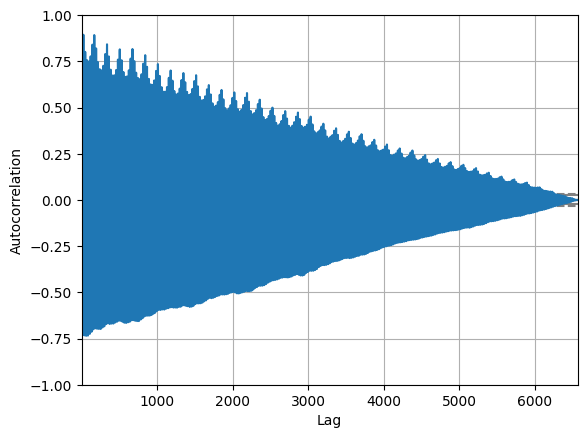

In [74]:
plot_acf = pd.plotting.autocorrelation_plot(data['passenger_demand'])
plt.show()

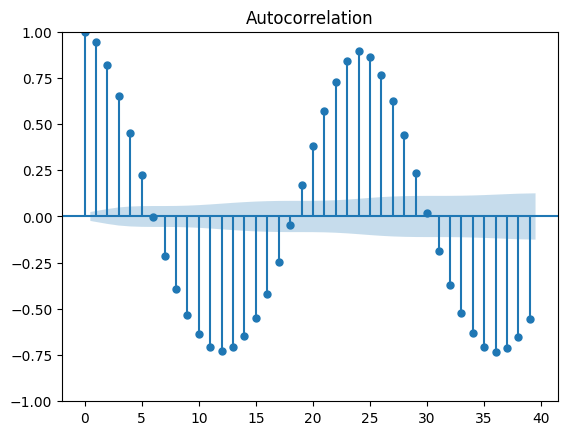

In [81]:
plot_acf(data['passenger_demand'])
plt.show()

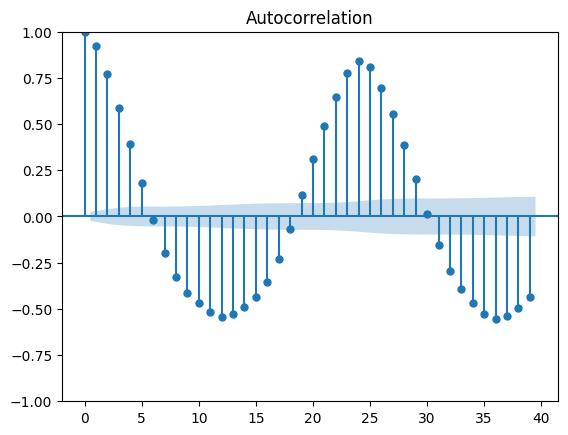

In [82]:
plot_acf(data['taxi_demand'])
plt.show()